<a href="https://colab.research.google.com/github/mhmmdluthfi/data-structurce-classroom-2020/blob/master/LSTM_GRU_Suara_Hati.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasifikasi Suara Jantung

## A. Mengimpor Library yang diperlukan

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
DATA_DIR = '/content/gdrive/MyDrive/heart_sound'

Mounted at /content/gdrive/


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # to use operating system dependent functionality
import librosa # to extract sound features
import wave # read and write WAV files
import matplotlib.pyplot as plt # to generate the visualizations
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns
import IPython.display as ipd
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from scipy import interp
from itertools import cycle

import keras
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import RMSprop

## B. Membaca Dataset & Ekstraksi Fitur

Suara Jantung Sehat

In [ ]:
# heart it
healthy_file=DATA_DIR+"/train/healthy/a0009.wav"
ipd.Audio(healthy_file)

In [ ]:
# Load use scipy
from scipy.io import wavfile
rate, data = wavfile.read(healthy_file)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  2000
Total samples (frames) =  (71611,)
[-134 -225 -278 ...  211  291  194]


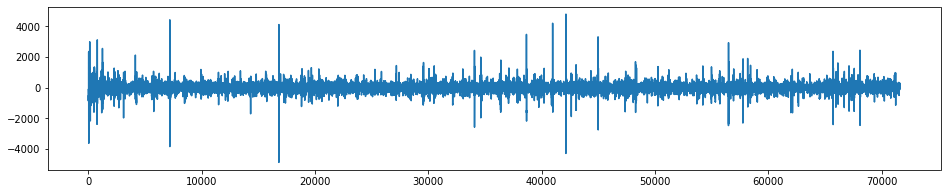

In [ ]:
# plot wave by audio frames
plt.figure(figsize=(16, 3))
plt.plot(data, '-', );


Suara Jantung Tidak Sehat

In [ ]:
unhealthy_file=DATA_DIR+"/train/unhealthy/a0001.wav"
ipd.Audio(unhealthy_file) 

In [ ]:
# Load use scipy
from scipy.io import wavfile
rate, data = wavfile.read(unhealthy_file)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  2000
Total samples (frames) =  (71332,)
[ -69 -135 -104 ... -285 -257 -187]


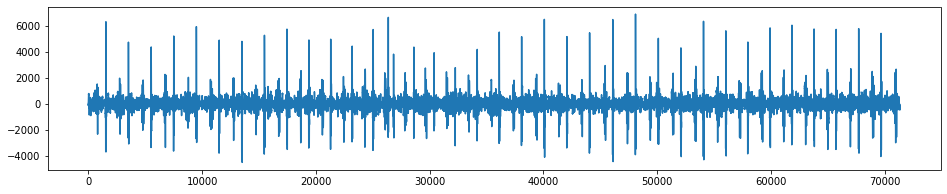

In [ ]:
# plot wave by audio frames
plt.figure(figsize=(16, 3))
plt.plot(data, '-', );

Ekstraksi menggunakan MFCC



In [ ]:
def extract_mfcc(wav_file_name):
    #This function extracts mfcc features and obtain the mean of each dimension
    #Input : path_to_wav_file
    #Output: mfcc_features'''
    y, sr = librosa.load(wav_file_name)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T,axis=0)
    
    return mfccs

In [ ]:
##### load heart sound dataset #####
heart_sound_labels = [] # to save extracted label/file
heart_sound_data = [] # to save extracted features/file
subset_dirs_list = ['healthy', 'unhealthy']

for dirname, dirs, filenames in os.walk(DATA_DIR+'/train/'):
    dirs[:] = [d for d in dirs if d in subset_dirs_list] # you can remove it to train the model over the entire dataset
    for filename in filenames[:500]:
        print(os.path.join(dirname, filename))
        heart_sound_labels.append(dirname)
        wav_file_name = os.path.join(dirname, filename)
        heart_sound_data.append(extract_mfcc(wav_file_name))

/content/gdrive/MyDrive/heart_sound/train/healthy/e00982.wav
/content/gdrive/MyDrive/heart_sound/train/healthy/e01142.wav
/content/gdrive/MyDrive/heart_sound/train/healthy/e01094.wav
/content/gdrive/MyDrive/heart_sound/train/healthy/e01072.wav
/content/gdrive/MyDrive/heart_sound/train/healthy/e01099.wav
/content/gdrive/MyDrive/heart_sound/train/healthy/e01109.wav
/content/gdrive/MyDrive/heart_sound/train/healthy/e01007.wav
/content/gdrive/MyDrive/heart_sound/train/healthy/e01083.wav
/content/gdrive/MyDrive/heart_sound/train/healthy/e01129.wav
/content/gdrive/MyDrive/heart_sound/train/healthy/e00993.wav
/content/gdrive/MyDrive/heart_sound/train/healthy/e01093.wav
/content/gdrive/MyDrive/heart_sound/train/healthy/e01096.wav
/content/gdrive/MyDrive/heart_sound/train/healthy/e00970.wav
/content/gdrive/MyDrive/heart_sound/train/healthy/e01011.wav
/content/gdrive/MyDrive/heart_sound/train/healthy/e01091.wav
/content/gdrive/MyDrive/heart_sound/train/healthy/e01006.wav
/content/gdrive/MyDrive/

In [ ]:
print(heart_sound_data[0])

[-3.8871002e+02  1.3892465e+02  9.8952888e+01  5.1492561e+01
  1.4615340e+01 -1.0892975e+00  3.4092684e+00  1.7839680e+01
  2.9493780e+01  3.0431330e+01  2.0918722e+01  7.6602278e+00
 -1.4322722e+00 -2.3407214e+00  3.1740789e+00  9.5958424e+00
  1.1760442e+01  8.1640263e+00  1.4404843e+00 -3.9433441e+00
 -4.9063611e+00 -1.6533734e+00  2.8479555e+00  5.1911964e+00
  3.8888910e+00  1.6465628e-01 -3.1876323e+00 -3.8951457e+00
 -1.7150207e+00  1.6135643e+00  3.7762253e+00  3.5384398e+00
  1.4726839e+00 -6.6054112e-01 -1.3057116e+00 -2.1532640e-01
  1.4971294e+00  2.3042653e+00  1.4483467e+00 -5.1705819e-01]


In [ ]:
from sklearn.preprocessing import LabelEncoder
#### convert data and label to array
heart_sound_data_array = np.asarray(heart_sound_data) # convert the input to an array
heart_sound_label_array = np.array(heart_sound_labels)

encoder = LabelEncoder()
heart_sound_label_array = encoder.fit_transform(heart_sound_label_array)

# print(heart_sound_data_array)
print(heart_sound_label_array)
#### make categorical labels
labels_categorical = heart_sound_label_array # converts a class vector (integers) to binary class matrix
heart_sound_data_array.shape
labels_categorical.shape

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

(1000,)

In [ ]:
from numpy import array
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = labels_categorical.reshape(len(labels_categorical), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


## C. Split Train dan Test

*  Split the dataset into training and testing sets: (training set) a subset to train a model, (test set) a subset to test the trained model.
*  **Note:**(train_test_split) function will split arrays or matrices into random train and test subsets, in our example, training set 80% and testing set 20% 

In [ ]:
x_train,x_test,y_train,y_test= train_test_split(np.array(heart_sound_data_array), onehot_encoded, test_size=0.20, random_state=9)
len(y_train), len(y_test)

(800, 200)

## D. Train and Test LSTM Classifier


* **What is Long short-term memory (LSTM)?**

Recurrent neural networks, of which LSTMs are the most powerful and well known subset, are a type of artificial neural network designed to recognize patterns in sequences of data, such as text, genomes, handwriting and the spoken word. **More Details:** (https://keras.io/layers/recurrent/#lstm) 

In [ ]:
# Define the LSTM model
def create_model_BiLSTM():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=False, input_shape=(40, 1))))
    model.add(Dense(64))
    model.add(Dropout(0.4))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(Dropout(0.4))
    model.add(Activation('relu'))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    
    # Configures the model for training
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [ ]:
model_BiLSTM = create_model_BiLSTM()
model_BiLSTM.build(input_shape=(None ,40, 1))

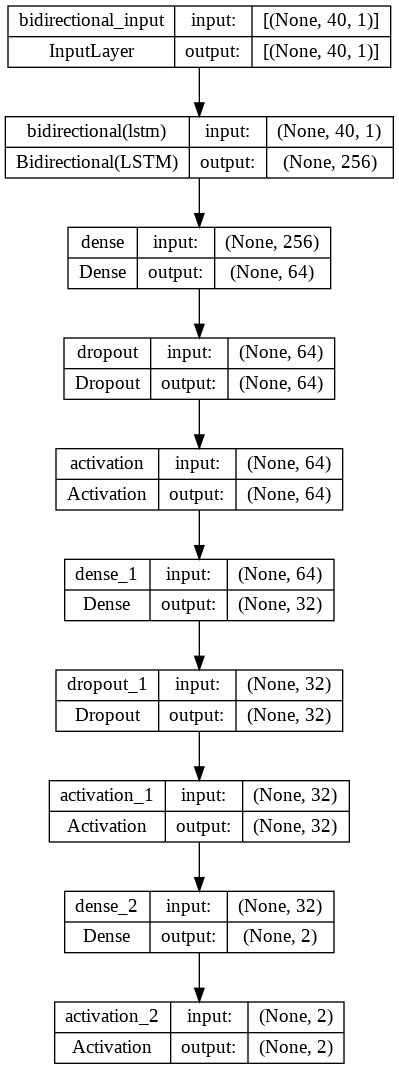

In [ ]:
# plot the model including the sizes of the model
tf.keras.utils.plot_model(model_BiLSTM, show_shapes=True)

In [ ]:
### train using LSTM model
model_A = create_model_BiLSTM()
# history = model_A.fit(np.expand_dims(heart_sound_data_array[:training_samples],-1), labels_categorical[:training_samples], validation_data=(np.expand_dims(heart_sound_data_array[training_samples:training_samples+validation_samples], -1), labels_categorical[training_samples:training_samples+validation_samples]), epochs=50, shuffle=True)
history = model_A.fit(np.expand_dims(x_train,-1),
                    y = y_train,
                    validation_data = (np.expand_dims(x_test,-1), y_test),
                    epochs=100,
                    shuffle = True)

Epoch 1/100
25/25 [==============================] - 8s 168ms/step - loss: 0.6291 - accuracy: 0.6388 - val_loss: 0.4833 - val_accuracy: 0.8000
Epoch 2/100
25/25 [==============================] - 2s 89ms/step - loss: 0.4343 - accuracy: 0.8225 - val_loss: 0.3450 - val_accuracy: 0.8450
Epoch 3/100
25/25 [==============================] - 2s 88ms/step - loss: 0.3494 - accuracy: 0.8575 - val_loss: 0.3260 - val_accuracy: 0.8600
Epoch 4/100
25/25 [==============================] - 2s 89ms/step - loss: 0.3276 - accuracy: 0.8750 - val_loss: 0.2926 - val_accuracy: 0.8700
Epoch 5/100
25/25 [==============================] - 2s 90ms/step - loss: 0.3100 - accuracy: 0.8925 - val_loss: 0.3700 - val_accuracy: 0.8450
Epoch 6/100
25/25 [==============================] - 2s 90ms/step - loss: 0.2601 - accuracy: 0.9050 - val_loss: 0.2797 - val_accuracy: 0.8700
Epoch 7/100
25/25 [==============================] - 2s 87ms/step - loss: 0.2869 - accuracy: 0.9000 - val_loss: 0.2741 - val_accuracy: 0.8800
Epoch

In [ ]:
model_A.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 256)              133120    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 activation_3 (Activation)   (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                      

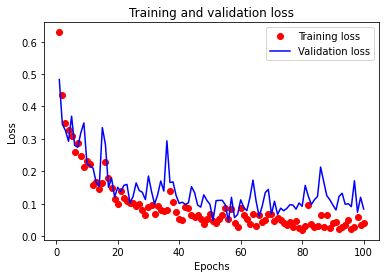

In [ ]:
### loss plots using LSTM model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

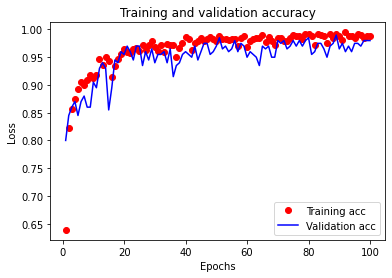

In [ ]:
### accuracy plots using LSTM model
plt.clf()                                                

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

*  **(evaluate function): Returns the loss value & metrics values for the model in test mode.**

In [ ]:
### evaluate using model A
model_A.evaluate(np.expand_dims(x_test, -1), y_test)

7/7 [==============================] - 0s 28ms/step - loss: 0.0835 - accuracy: 0.9800


[0.08349721133708954, 0.9800000190734863]

* **Save the weights of the model as a HDF5 file**

In [ ]:
model_A.save_weights("Model_LSTM.h5")

In [ ]:
y_pred = model_A.predict(np.expand_dims(x_test,-1))
y_pred = np.argmax(y_pred, axis=1)
# y_test = np.expand_dims(y_test,-1)
y_true = np.argmax(y_test, axis=1)
y_true

conf_heart_sound = confusion_matrix(y_true=y_true, y_pred=y_pred)

7/7 [==============================] - 1s 28ms/step


[Text(0, 0.5, 'healthy'), Text(0, 1.5, 'unhealthy')]

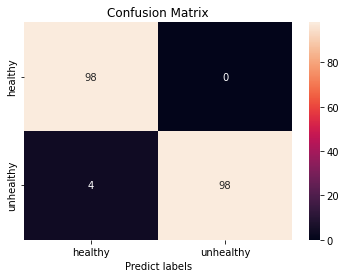

In [ ]:
ax = plt.subplot()
sns.heatmap(conf_heart_sound, annot= True, ax = ax)

ax.set_xlabel('Predict labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['healthy','unhealthy'])
ax.yaxis.set_ticklabels(['healthy','unhealthy'])

In [ ]:
# Menampilkan nilai presisi, recall, dan F1-score
pred_A = model_A.predict(np.expand_dims(x_test, -1))
modelA_predicted = np.argmax(pred_A, axis = 1)

File=["Healthy", "Unhealthy"]
print(classification_report(y_test.argmax(axis=1), modelA_predicted, target_names=File))

7/7 [==============================] - 0s 31ms/step
              precision    recall  f1-score   support

     Healthy       0.96      1.00      0.98        98
   Unhealthy       1.00      0.96      0.98       102

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



In [ ]:
# Menampilkan kurva AUC-ROC
Y_pred = model_A.predict(np.expand_dims(x_test, -1))

7/7 [==============================] - 0s 28ms/step


In [ ]:
n_classes = 2
lw = 1
Y_val = y_test
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_val[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_val.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

<ipython-input-29-c858286738c8>:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


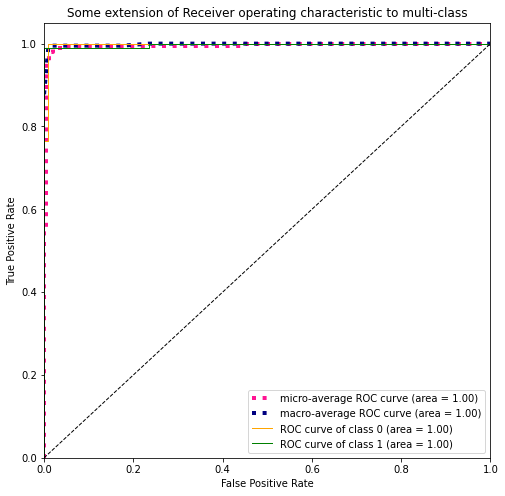

In [ ]:
# Pertama-tama, gabungkan semua False Positive Rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Kemudian interpolasi semua kurva ROC pada titik ini
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Terakhir, rata-rata dan hitung AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot semua kurva ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['orange', 'green', 'blue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## E. GRU

In [ ]:
# Define the GRU model
def create_model_BiGRU():
    model = Sequential()
    model.add(Bidirectional(GRU(128, return_sequences=False, input_shape=(40, 1))))
    model.add(Dense(64))
    model.add(Dropout(0.4))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(Dropout(0.4))
    model.add(Activation('relu'))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    
    # Configures the model for training
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [ ]:
model_BiGRU = create_model_BiGRU()
model_BiGRU.build(input_shape=(None ,40, 1))

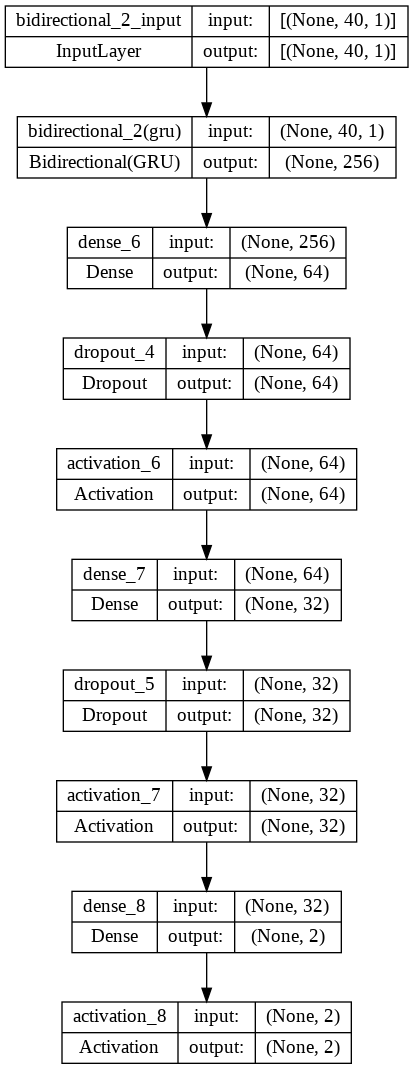

In [ ]:
tf.keras.utils.plot_model(model_BiGRU, show_shapes=True)

In [ ]:
### train using GRU model
model_B = create_model_BiGRU()
# history = model_B.fit(np.expand_dims(heart_sound_data_array[:training_samples],-1), labels_categorical[:training_samples], validation_data=(np.expand_dims(heart_sound_data_array[training_samples:training_samples+validation_samples], -1), labels_categorical[training_samples:training_samples+validation_samples]), epochs=50, shuffle=True)
history = model_B.fit(np.expand_dims(x_train, -1),
                      y = y_train,
                      validation_data = (np.expand_dims(x_test, -1), y_test), 
                      epochs = 100, 
                      shuffle=True)

Epoch 1/100
25/25 [==============================] - 7s 118ms/step - loss: 0.7162 - accuracy: 0.5525 - val_loss: 0.6273 - val_accuracy: 0.7350
Epoch 2/100
25/25 [==============================] - 1s 60ms/step - loss: 0.5519 - accuracy: 0.7362 - val_loss: 0.5160 - val_accuracy: 0.7700
Epoch 3/100
25/25 [==============================] - 1s 58ms/step - loss: 0.4719 - accuracy: 0.7987 - val_loss: 0.4638 - val_accuracy: 0.7900
Epoch 4/100
25/25 [==============================] - 1s 60ms/step - loss: 0.4491 - accuracy: 0.8100 - val_loss: 0.5022 - val_accuracy: 0.8200
Epoch 5/100
25/25 [==============================] - 1s 59ms/step - loss: 0.4031 - accuracy: 0.8475 - val_loss: 0.4076 - val_accuracy: 0.8250
Epoch 6/100
25/25 [==============================] - 1s 57ms/step - loss: 0.3765 - accuracy: 0.8575 - val_loss: 0.3962 - val_accuracy: 0.8400
Epoch 7/100
25/25 [==============================] - 1s 60ms/step - loss: 0.3501 - accuracy: 0.8737 - val_loss: 0.3714 - val_accuracy: 0.8500
Epoch

In [ ]:
model_B.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 256)              100608    
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 64)                16448     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 activation_9 (Activation)   (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                      

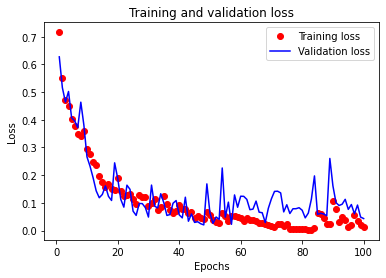

In [ ]:
### loss plots using GRU model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

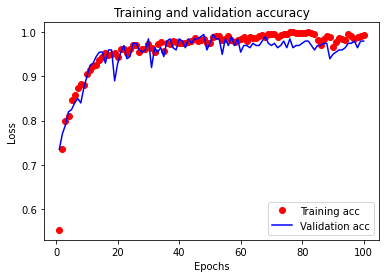

In [ ]:
### accuracy plots using GRU model
plt.clf()                                                

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
### evaluate using model B
model_B.evaluate(np.expand_dims(x_test, -1), y_test)

7/7 [==============================] - 0s 12ms/step - loss: 0.0432 - accuracy: 0.9800


[0.04317435622215271, 0.9800000190734863]

In [ ]:
model_B.save_weights("Model_GRU.h5")

In [ ]:
y_pred = model_B.predict(np.expand_dims(x_test,-1))
y_pred = np.argmax(y_pred, axis=1)
# y_test = np.expand_dims(y_test,-1)
y_true = np.argmax(y_test, axis=1)
y_true

conf_heart_sound = confusion_matrix(y_true=y_true, y_pred=y_pred)

7/7 [==============================] - 1s 16ms/step


[Text(0, 0.5, 'healthy'), Text(0, 1.5, 'unhealthy')]

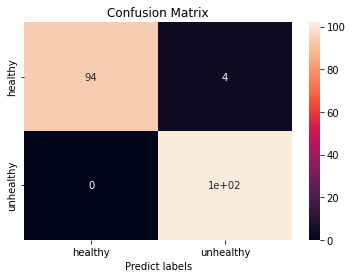

In [ ]:
ax = plt.subplot()
sns.heatmap(conf_heart_sound, annot= True, ax = ax)

ax.set_xlabel('Predict labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['healthy','unhealthy'])
ax.yaxis.set_ticklabels(['healthy','unhealthy'])

In [ ]:
# Menampilkan nilai presisi, recall, dan F1-score
pred_B = model_B.predict(np.expand_dims(x_test, -1))
modelB_predicted = np.argmax(pred_B, axis = 1)

File=["Healthy", "Unhealthy"]
print(classification_report(y_test.argmax(axis=1), modelB_predicted, target_names=File))

7/7 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

     Healthy       1.00      0.96      0.98        98
   Unhealthy       0.96      1.00      0.98       102

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



In [ ]:
# Menampilkan kurva AUC-ROC
Y_pred = model_B.predict(np.expand_dims(x_test, -1))

7/7 [==============================] - 0s 13ms/step


In [ ]:
n_classes = 2
lw = 2
Y_val = y_test
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_val[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_val.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

<ipython-input-44-c858286738c8>:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


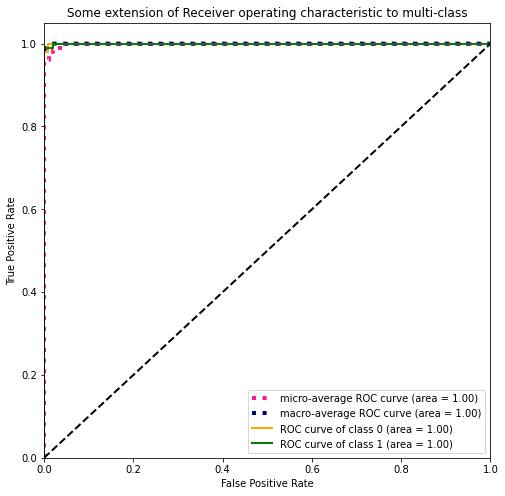

In [ ]:
# Pertama-tama, gabungkan semua False Positive Rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Kemudian interpolasi semua kurva ROC pada titik ini
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Terakhir, rata-rata dan hitung AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot semua kurva ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['orange', 'green', 'blue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()